# ODE error sensivity analysis
(12.9.16)

The purpose of this notebook is to test the tradeoff between different absolute/relative error sensivities and the solution times.

rel = 1e-3
abs = 1e-6 

seems a good tradeoff.

edit: looking at the heatmaps i now prefer
rel = 1e-5 / 1e-4 / 1e-3
abs = 1e-6 / 1e-5 / 1e-4

For further improvement one should probably use vectorvalued absolute errors.

In [1]:
include("../src/gyncycle.jl");

In [2]:
using Sundials, Plots; pyplot();

In [ ]:
const ts   = Float64[0:60];
const corr = gync(refy0, refallparms, ts, reltol=1e-10, abstol=1e-9);
const measuredinds = [2,7,24,25];

function sensanalysis(r=1e-3, a=1e-3)
  try
    t = @elapsed test = gync(refy0, refallparms, ts, reltol=r, abstol=a)
    #corr = gync(refy0, refallparms, ts, 1e-9, 1e-9)
    reldiff = ((test-corr) ./ mean(corr,1))[:,measuredinds]
    e = sqrt(sumabs2(reldiff)) / (length(ts) * length(measuredinds))
    #ps=[plot(hcat(test[:,s], corr[:,s]), title="$(e[i]) ", label=[(r,a) "true"], size=(600,500)) for (i,s) in enumerate(measuredinds)]
    #plot(ps..., reuse=false)
    return [t,e]
  catch
    return [NaN, NaN]
  end
end;

In [27]:
N = 100
x = y = logspace(-2, -9, N)
X = repmat(x', length(y), 1)
Y = repmat(y, 1, length(x))
@time Z = map(sensanalysis, X, Y);

180.432514 seconds (171.48 M allocations: 5.231 GB, 1.44% gc time)


In [29]:
# construct time error 3-d matrix from the sensanalysis results
TE=Float64[Z[i,j][k] for i=1:size(Z,1), j=1:size(Z,2), k=1:length(Z[1,1])];


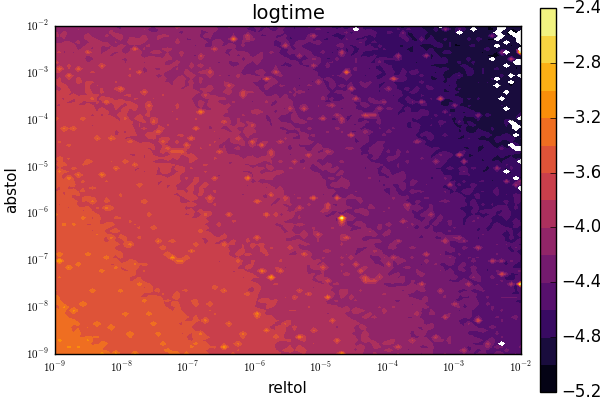


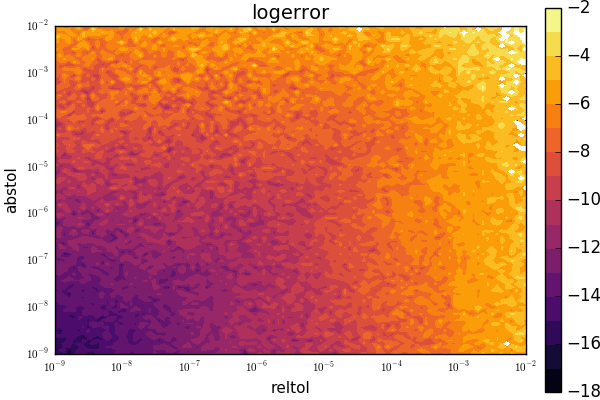

In [30]:
map([1,2], ["logtime", "logerror"]) do i, t
    c = contour(x,y,TE[:,:,i]|>log, xaxis=:log, yaxis=:log, zaxis=:log, fill=true, xlabel="reltol", ylabel="abstol", title=t)
    display(c)
end;

The following code reduces the set of all tested points to those feasible for optimizing any monotone objective in time and error.

It first looks for levelsets in time and finds the best points in error, and then intersects these with the respectively exchanged best points, discarding all points that are infeasible for the maximization.

In [36]:
steps = 50

quantile = 0.1


# fix levelsets of A and find maxima of B
function fixopt(A, B; bins = 30, quantile = 0.1)
  mn,mx = extrema(A)
  step  = (mx-mn) / bins

  res = []

  for c in 1:bins
     inds = find(x->step*(c-1)<=x-mn<=step*c, A)
     if length(inds) > 0
          mx2 = maximum(B[inds])
          inds2 = find(x->mx2*(1-quantile)<=x, B[inds])
          push!(res, inds[inds2]...)
     end
  end

  subs = [ind2sub(size(A), ind) for ind in res]
end

# find feasible points for maximization of monotone obj in the given points
function monopt(A, B; bins = 30, quantile = 0.1)
    s1 = fixopt(A, B; bins = bins, quantile = quantile) 
    s2 = fixopt(B, A; bins = bins, quantile = quantile) |> Set
    
    intersect(s1, s2)
end

monopt (generic function with 1 method)

length(f) = 31



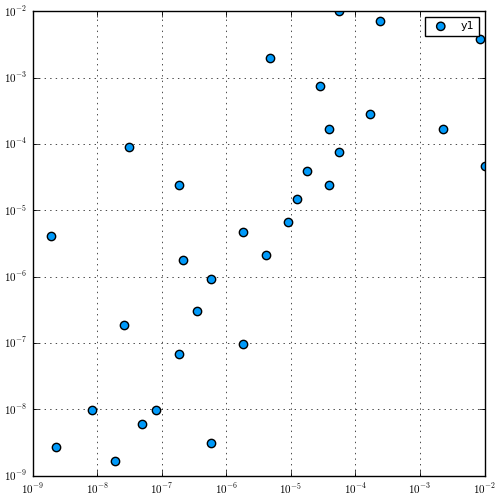

In [57]:
T, E = log(TE[:,:,1]), log(TE[:,:,2])

f=monopt(-T,-E, bins=40, quantile=0.01)

@show length(f)

sub2array(ss) = [ss[i][j] for i=1:length(ss), j=1:2]
ss = sub2array(f);

xx=x[ss[:,1]]
yy=y[ss[:,2]]

scatter(xx, yy, xaxis=:log, yaxis=:log, xlim=extrema(x), ylim=extrema(y), size=(500,500))

This scheme works for any given criteria f which the final criterion g depends monotonely on:
$$ \mathbb{R}^n \overset{f}{\longrightarrow} \mathbb{R}^n \overset{g}{\longrightarrow} \mathbb{R}$$

Although this is a rudementary not very stable implementation (with 2 parameters), looking at the analytic version (looking for points with orthogonal gradients) one might try to find more stable implementations.

# Time-error tradeof with almost optimal abs/reltol relation 1:1


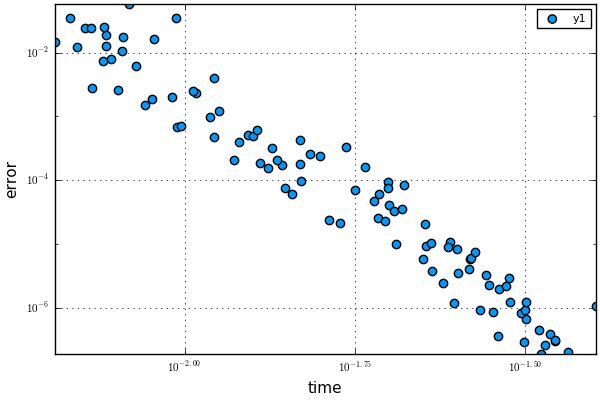

In [47]:
n=size(TE,1)
scatter([TE[i,i,1] for i=1:n], [TE[i,i,2] for i=1:n], xaxis=(:log, "time"), yaxis=(:log, "error"))

# old tests
manually testing for parameter estimates

In [3]:
function sensanalysis(r=1e-3, a=1e-3, measuredinds=[2,7,24,25], ts=Float64[0:60;])
  @time test = gync(refy0, refallparms, ts, r, a)
  corr = gync(refy0, refallparms, ts, 1e-9, 1e-9)
  reldiff = ((test-corr) ./ mean(corr,1))[:,measuredinds]
  e = sqrt(sumabs2(reldiff,1)) / length(ts)
  ps=[plot(hcat(test[:,s], corr[:,s]), title="$(e[i]) ", label=[(r,a) "true"], size=(600,500)) for (i,s) in enumerate(measuredinds)]
  plot(ps..., reuse=false)
end;


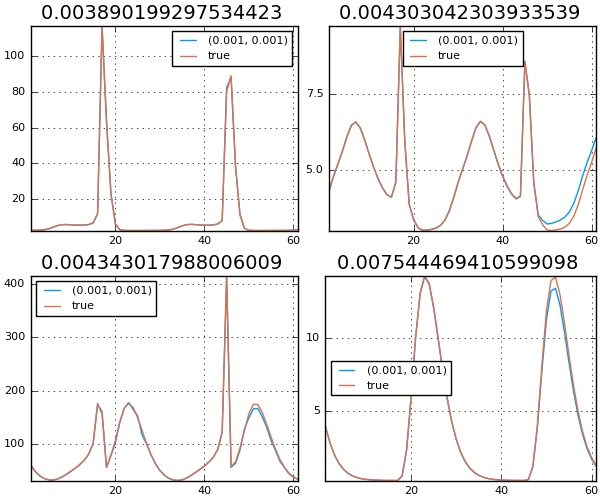

  0.007800 seconds (8.59 k allocations: 265.922 KB)
 


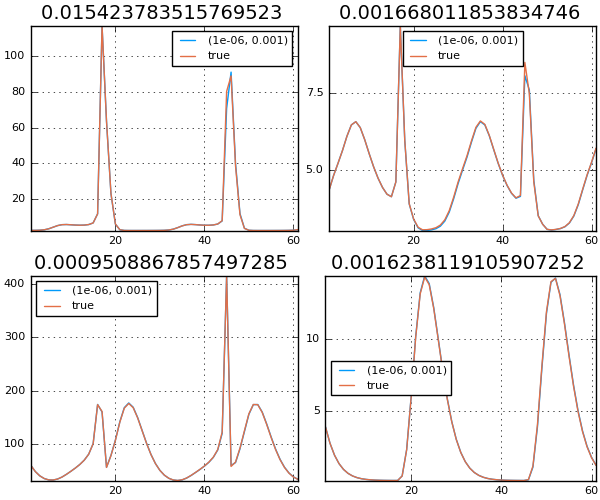

 0.016506 seconds (15.44 k allocations: 464.781 KB)
 


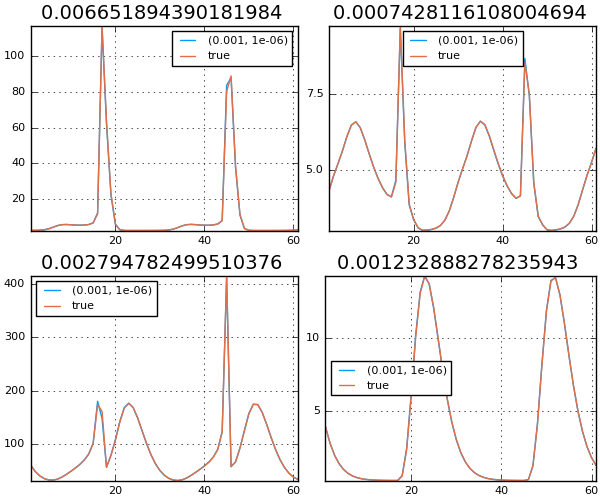

 0.010698 seconds (11.18 k allocations: 341.078 KB)
 


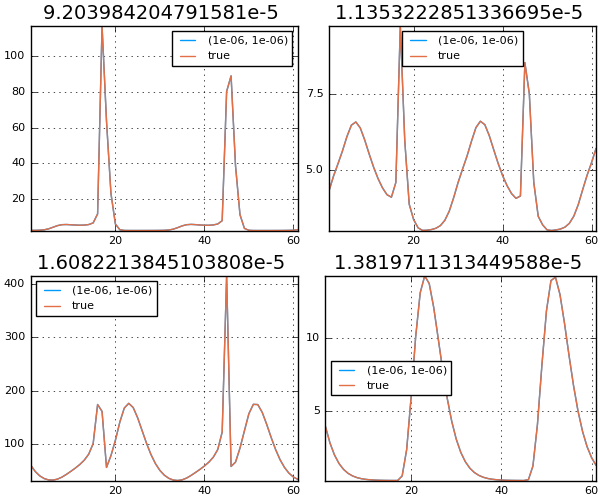

 0.019159 seconds (17.71 k allocations: 530.797 KB)
 


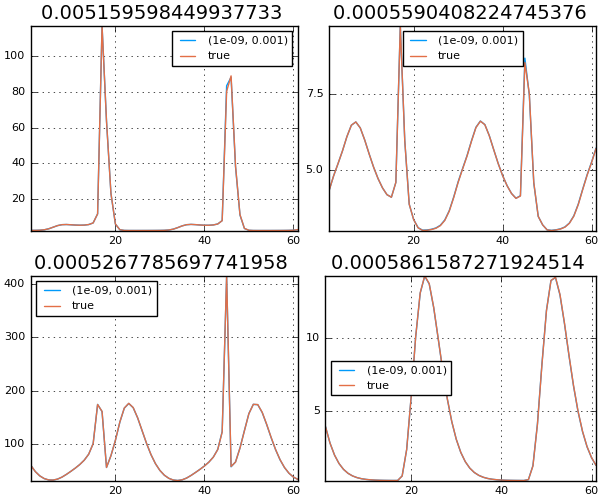

 0.020200 seconds (18.52 k allocations: 554.156 KB)
 


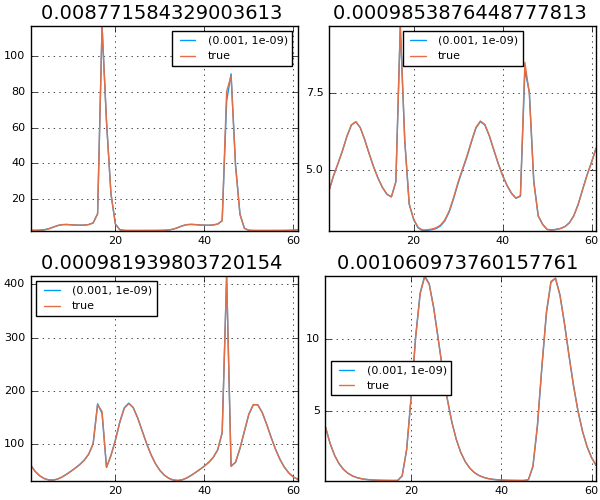

 0.015175 seconds (14.27 k allocations: 430.859 KB)


In [7]:
map(sensanalysis, zip([1e-3,1e-3], [1e-6, 1e-3], [1e-3, 1e-6], [1e-6, 1e-6], [1e-9, 1e-3], [1e-3, 1e-9])...);


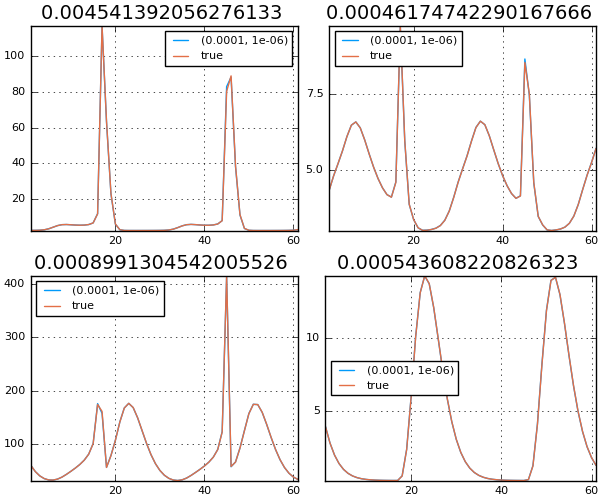

  0.013266 seconds (12.57 k allocations: 381.500 KB)


In [6]:
# cvodes.jl default
sensanalysis(1e-4, 1e-6)

## optimization of the right hand side

optimization of rhs:
- ParallelAccelerator slowed down by 2x
- yeppp only good for vectors
- fastmath no difference
- minor speedup (5%) by exponentiating only once in hplus

optimization of gync:
- inconsistent results when changing initial values
- no difference in exchanging the anonymous function to FastAnonymous, closure remains a problem...